In [1]:
import torch

# Check if CUDA (GPU support) is available
print("CUDA Available:", torch.cuda.is_available())

# Print GPU device name (if available)
if torch.cuda.is_available():
    print("GPU Device Name:", torch.cuda.get_device_name(0))
    print("Number of GPUs Available:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())
else:
    print("GPU not detected. Running on CPU.")


CUDA Available: True
GPU Device Name: NVIDIA GeForce RTX 2050
Number of GPUs Available: 1
Current GPU: 0


In [3]:
# Standard Libraries
import os
import sys
import time
import random
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict

# PyTorch Core
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.utils import make_grid

# Image Processing
%pip install opencv-python
from PIL import Image, ImageEnhance, ImageFilter
import cv2

# Pretrained Models (timm)
%pip install timm
import timm
from timm import create_model

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Progress Bar
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Timm version: {timm.__version__}")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


c:\Users\shrin\anaconda3\envs\tf-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries imported successfully!
PyTorch version: 2.7.1+cu118
Torchvision version: 0.22.1+cu118
Timm version: 1.0.17


In [14]:
# Step 1: Dataset Loading and Preprocessing

# ImageNet normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Image size
IMG_SIZE = 224

# Enhanced image quality functions for chest X-ray images
def apply_clahe_enhancement(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for local contrast enhancement
    """
    # Convert PIL to numpy array
    img_array = np.array(image)
    
    # Convert to grayscale if RGB
    if len(img_array.shape) == 3:
        img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img_array
    
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    img_clahe = clahe.apply(img_gray)
    
    # Convert back to RGB format for PIL
    if len(img_array.shape) == 3:
        img_clahe_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)
    else:
        img_clahe_rgb = np.stack([img_clahe] * 3, axis=-1)
    
    # Convert back to PIL Image
    return Image.fromarray(img_clahe_rgb.astype(np.uint8))

def enhance_contrast(image, factor=1.3):
    """Enhance contrast using PIL ImageEnhance"""
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(factor)

def enhance_sharpness(image, factor=1.5):
    """Enhance sharpness using PIL ImageEnhance"""
    enhancer = ImageEnhance.Sharpness(image)
    return enhancer.enhance(factor)

def enhance_brightness(image, factor=1.1):
    """Slightly enhance brightness for better visibility"""
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(factor)

def comprehensive_xray_enhancement(image):
    """
    Comprehensive enhancement pipeline for chest X-ray images
    Combines CLAHE, contrast, sharpness, and brightness enhancements
    """
    try:
        # Step 1: Apply CLAHE for local contrast enhancement
        # Randomize CLAHE parameters for augmentation
        clip_limit = random.uniform(1.5, 3.0)
        tile_size = random.choice([(6, 6), (8, 8), (10, 10)])
        image = apply_clahe_enhancement(image, clip_limit=clip_limit, tile_grid_size=tile_size)
        
        # Step 2: Global contrast enhancement
        contrast_factor = random.uniform(1.2, 1.6)
        image = enhance_contrast(image, factor=contrast_factor)
        
        # Step 3: Sharpness enhancement for better edge definition
        sharpness_factor = random.uniform(1.3, 2.2)
        image = enhance_sharpness(image, factor=sharpness_factor)
        
        # Step 4: Slight brightness boost for better visibility
        brightness_factor = random.uniform(1.05, 1.15)
        image = enhance_brightness(image, factor=brightness_factor)
        
        return image
        
    except Exception as e:
        print(f"Warning: Enhancement failed for image, using original: {e}")
        return image

# Define transforms for different dataset splits
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # Comprehensive X-ray quality enhancement (training only)
    transforms.Lambda(comprehensive_xray_enhancement),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Dataset paths for your folder structure
data_root = Path('e:/covid_19/dataset')
train_path = data_root / 'train'
val_path = data_root / 'val'
test_path = data_root / 'test'

def load_covid_datasets(train_path, val_path, test_path):
    """
    Load COVID-19 datasets using ImageFolder
    
    Expected folder structure:
    dataset/
    ├── train/
    │   ├── covid/
    │   └── normal/
    ├── val/
    │   ├── covid/
    │   └── normal/
    └── test/
        ├── covid/
        └── normal/
    """
    
    # Check if paths exist
    for split_name, path in [('train', train_path), ('val', val_path), ('test', test_path)]:
        if not path.exists():
            print(f"Warning: {split_name} path {path} does not exist!")
            return None, None, None
        
        # Check if class folders exist
        covid_path = path / 'covid'
        normal_path = path / 'normal'
        if not covid_path.exists() or not normal_path.exists():
            print(f"Warning: Missing covid or normal folders in {path}")
            return None, None, None
    
    # Create datasets
    train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
    val_dataset = datasets.ImageFolder(root=val_path, transform=val_transforms)
    test_dataset = datasets.ImageFolder(root=test_path, transform=test_transforms)
    
    # Print dataset information
    print("COVID-19 Dataset Information:")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Number of classes: {len(train_dataset.classes)}")
    print(f"Class names: {train_dataset.classes}")
    print(f"Class to index mapping: {train_dataset.class_to_idx}")
    
    # Count samples per class in each split
    for split_name, dataset in [('Train', train_dataset), ('Val', val_dataset), ('Test', test_dataset)]:
        class_counts = defaultdict(int)
        for _, label in dataset:
            class_name = dataset.classes[label]
            class_counts[class_name] += 1
        print(f"\n{split_name} class distribution:")
        for class_name, count in class_counts.items():
            print(f"  {class_name}: {count} samples")
    
    return train_dataset, val_dataset, test_dataset

def create_covid_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=32, num_workers=0):
    """
    Create DataLoaders for COVID-19 classification
    Note: num_workers=0 to avoid Windows multiprocessing issues
    """
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
        drop_last=True  # For stable training
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    
    print(f"\nDataLoaders created with batch size: {batch_size}")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")
    
    return train_loader, val_loader, test_loader

# Load COVID-19 datasets
print("Loading COVID-19 datasets...")
train_dataset, val_dataset, test_dataset = load_covid_datasets(train_path, val_path, test_path)

# Create DataLoaders (if datasets were loaded successfully)
if train_dataset is not None:
    train_loader, val_loader, test_loader = create_covid_dataloaders(
        train_dataset, val_dataset, test_dataset, 
        batch_size=32, 
        num_workers=0  # Set to 0 to avoid Windows multiprocessing issues
    )
    
    # Display sample batch information with error handling
    try:
        sample_batch = next(iter(train_loader))
        images, labels = sample_batch
        print(f"\nSample batch information:")
        print(f"Images shape: {images.shape}")
        print(f"Labels shape: {labels.shape}")
        print(f"Image tensor range: [{images.min():.3f}, {images.max():.3f}]")
        print(f"Sample labels: {labels[:10].tolist()}")  # Show first 10 labels
        
        # Get class names for reference
        class_names = train_dataset.classes
        print(f"Class mapping: {dict(enumerate(class_names))}")
        
    except Exception as e:
        print(f"Error loading sample batch: {e}")
        print("This might be due to transform issues or corrupted images.")
    
else:
    print("Datasets could not be loaded. Please check your data paths and folder structure.")
    print(f"Expected structure:")
    print(f"  {data_root}/")
    print(f"  ├── train/")
    print(f"  │   ├── covid/")
    print(f"  │   └── normal/")
    print(f"  ├── val/")
    print(f"  │   ├── covid/")
    print(f"  │   └── normal/")
    print(f"  └── test/")
    print(f"      ├── covid/")
    print(f"      └── normal/")

Loading COVID-19 datasets...
COVID-19 Dataset Information:
Training samples: 750
Validation samples: 200
Test samples: 50
Number of classes: 2
Class names: ['covid', 'normal']
Class to index mapping: {'covid': 0, 'normal': 1}

Train class distribution:
  covid: 375 samples
  normal: 375 samples

Train class distribution:
  covid: 375 samples
  normal: 375 samples

Val class distribution:
  covid: 100 samples
  normal: 100 samples

Test class distribution:
  covid: 25 samples
  normal: 25 samples

DataLoaders created with batch size: 32
Training batches: 23
Validation batches: 7
Test batches: 2

Val class distribution:
  covid: 100 samples
  normal: 100 samples

Test class distribution:
  covid: 25 samples
  normal: 25 samples

DataLoaders created with batch size: 32
Training batches: 23
Validation batches: 7
Test batches: 2

Sample batch information:
Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Image tensor range: [-2.118, 2.640]
Sample labels: [0, 0, 0, 0

Visualizing dataset...


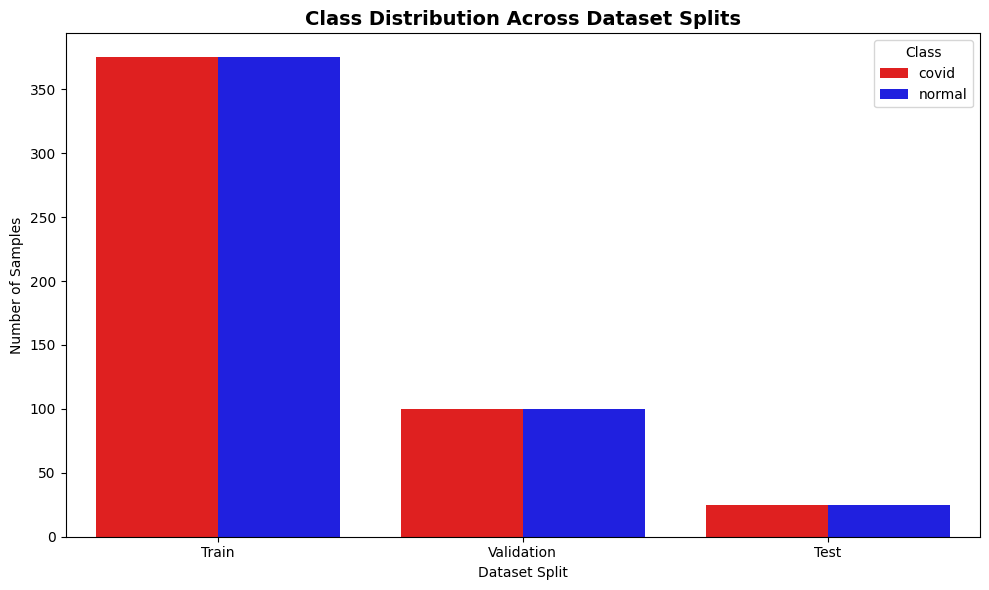


Class Distribution Summary:
Class       covid  normal
Split                    
Test           25      25
Train         375     375
Validation    100     100

Displaying sample training images...


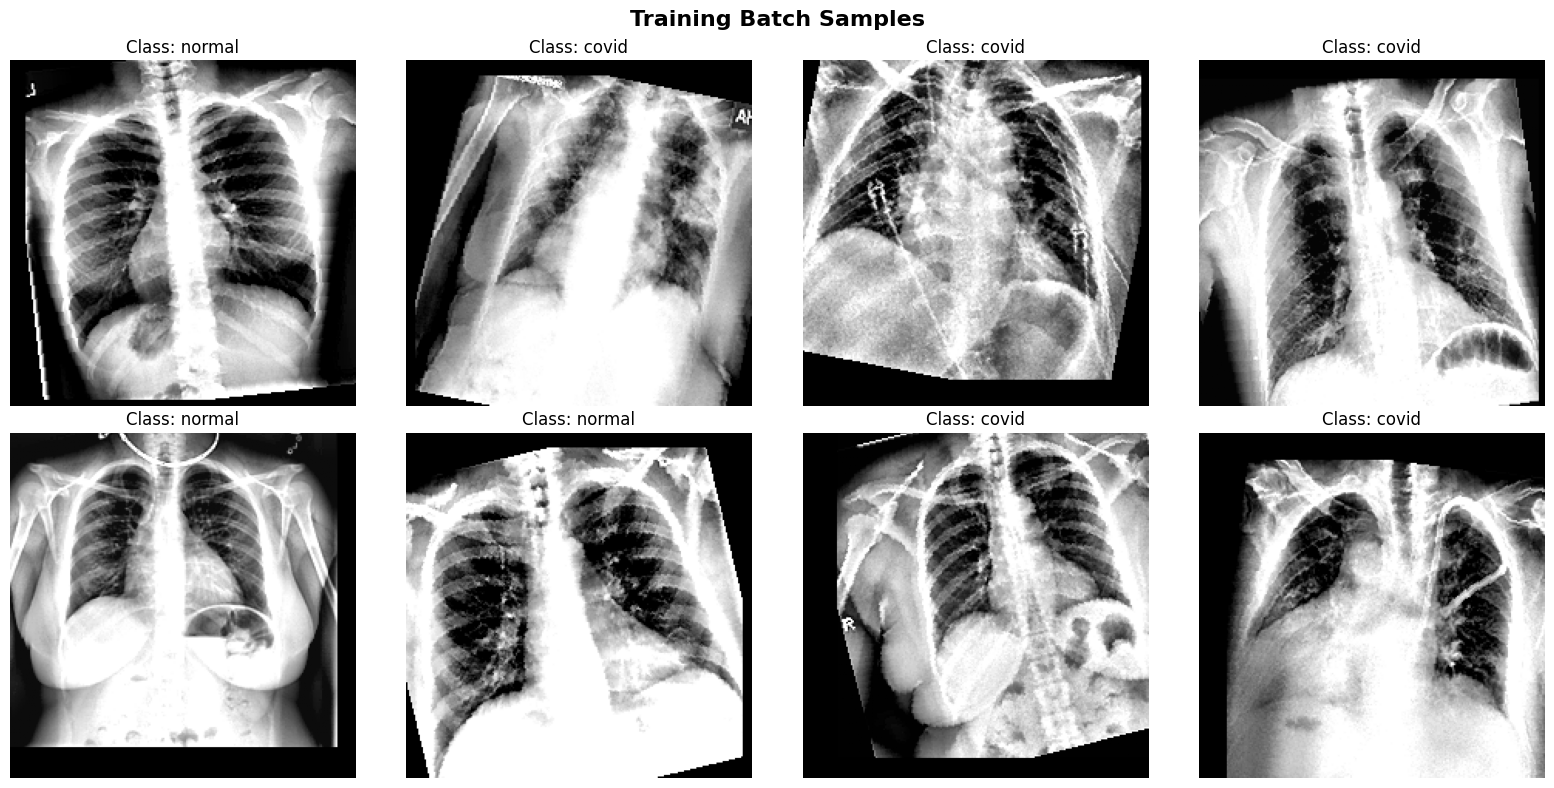


Displaying sample validation images...


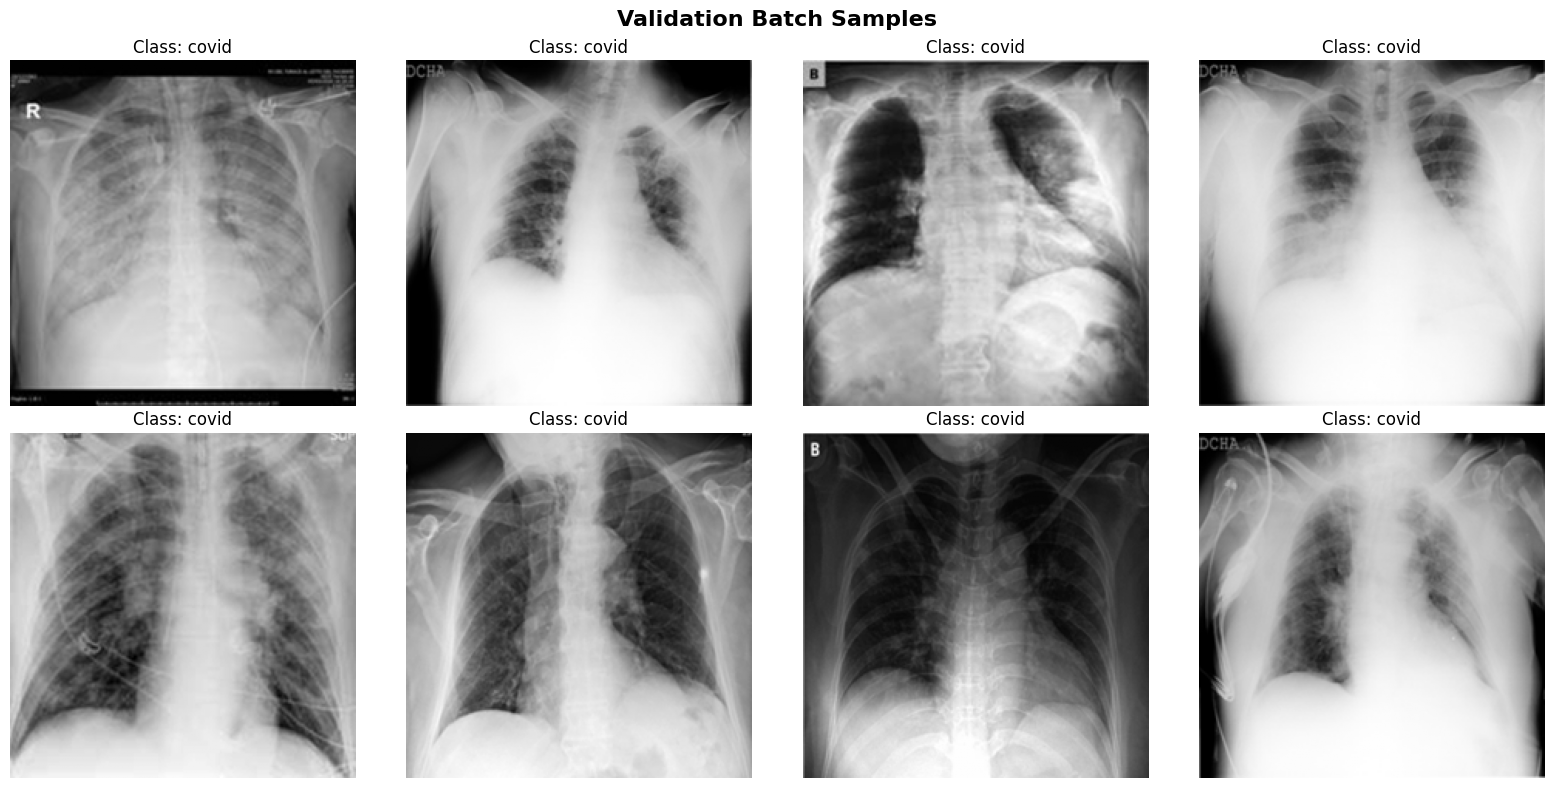

In [15]:
# Step 2: Dataset Visualization and Exploration

def denormalize_tensor(tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """
    Denormalize a tensor for visualization
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

def visualize_batch_samples(data_loader, class_names, title="Batch Samples", num_samples=8):
    """
    Visualize sample images from a batch
    """
    try:
        # Get a batch
        images, labels = next(iter(data_loader))
        
        # Select samples to display
        num_samples = min(num_samples, len(images))
        
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        fig.suptitle(title, fontsize=16, fontweight='bold')
        
        for i in range(num_samples):
            row = i // 4
            col = i % 4
            
            # Denormalize and convert to displayable format
            img = denormalize_tensor(images[i])
            img = torch.clamp(img, 0, 1)
            img_np = img.permute(1, 2, 0).numpy()
            
            # Convert to grayscale if needed (for X-ray images)
            if img_np.shape[2] == 3:
                img_np = np.mean(img_np, axis=2)
            
            axes[row, col].imshow(img_np, cmap='gray')
            axes[row, col].set_title(f'Class: {class_names[labels[i]]}', fontsize=12)
            axes[row, col].axis('off')
        
        # Hide empty subplots
        for i in range(num_samples, 8):
            row = i // 4
            col = i % 4
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error visualizing batch: {e}")

def plot_class_distribution(train_dataset, val_dataset, test_dataset):
    """
    Plot class distribution across train, validation, and test sets
    """
    # Count classes
    datasets = {'Train': train_dataset, 'Validation': val_dataset, 'Test': test_dataset}
    class_names = train_dataset.classes
    
    data_for_plot = []
    
    for split_name, dataset in datasets.items():
        class_counts = defaultdict(int)
        for _, label in dataset:
            class_name = dataset.classes[label]
            class_counts[class_name] += 1
        
        for class_name in class_names:
            data_for_plot.append({
                'Split': split_name,
                'Class': class_name,
                'Count': class_counts[class_name]
            })
    
    df = pd.DataFrame(data_for_plot)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Split', y='Count', hue='Class', palette=['red', 'blue'])
    plt.title('Class Distribution Across Dataset Splits', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Samples')
    plt.xlabel('Dataset Split')
    plt.legend(title='Class')
    plt.tight_layout()
    plt.show()
    
    return df

# Visualize the dataset if it was loaded successfully
if train_dataset is not None and 'train_loader' in locals():
    print("Visualizing dataset...")
    
    # Plot class distribution
    distribution_df = plot_class_distribution(train_dataset, val_dataset, test_dataset)
    print("\nClass Distribution Summary:")
    print(distribution_df.pivot(index='Split', columns='Class', values='Count'))
    
    # Visualize sample images from training set
    print("\nDisplaying sample training images...")
    visualize_batch_samples(train_loader, train_dataset.classes, "Training Batch Samples")
    
    # Visualize sample images from validation set
    print("\nDisplaying sample validation images...")
    visualize_batch_samples(val_loader, val_dataset.classes, "Validation Batch Samples")
    
else:
    print("Cannot visualize dataset - data loading failed.")

In [17]:
# Step 3: Model Definition and Training Pipeline

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def create_covid_model(model_name='efficientnet_b0', num_classes=2, pretrained=True):
    """
    Create a pretrained model for COVID-19 classification
    """
    if model_name == 'efficientnet_b0':
        # Using timm for EfficientNet
        model = timm.create_model('efficientnet_b0', pretrained=pretrained, num_classes=num_classes)
        print(f"Created EfficientNet-B0 model with {num_classes} classes")
    elif model_name == 'resnet50':
        # Using torchvision ResNet50
        model = models.resnet50(pretrained=pretrained)
        # Replace the classifier
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
        print(f"Created ResNet-50 model with {num_classes} classes")
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    
    return model

def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch
    """
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        # Update progress bar
        accuracy = 100.0 * correct_predictions / total_samples
        progress_bar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{accuracy:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct_predictions / total_samples
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model for one epoch
    """
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validation", leave=False)
        
        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            # Update progress bar
            accuracy = 100.0 * correct_predictions / total_samples
            progress_bar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{accuracy:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100.0 * correct_predictions / total_samples
    
    return epoch_loss, epoch_acc

class EarlyStopping:
    """
    Early stopping to stop training when validation loss doesn't improve
    """
    def __init__(self, patience=5, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def train_covid_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001, 
                     patience=5, save_path='e:/covid_19/best_covid_model.pth'):
    """
    Complete training pipeline for COVID-19 classification model
    """
    # Move model to device
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # Learning rate scheduler (removed verbose parameter for compatibility)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    # Early stopping
    early_stopping = EarlyStopping(patience=patience)
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }
    
    print(f"Starting training for {num_epochs} epochs...")
    print(f"Model will be saved to: {save_path}")
    print("-" * 80)
    
    best_val_loss = float('inf')
    prev_lr = learning_rate
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation phase
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Manual logging for learning rate changes
        if current_lr != prev_lr:
            print(f"Learning rate reduced from {prev_lr:.6f} to {current_lr:.6f}")
            prev_lr = current_lr
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Print epoch results
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {current_lr:.6f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                'train_loss': train_loss,
                'train_acc': train_acc
            }, save_path)
            print(f"✓ New best model saved! (Val Loss: {val_loss:.4f})")
        
        # Early stopping check
        if early_stopping(val_loss, model):
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break
        
        print("-" * 40)
    
    print("Training completed!")
    print(f"Best validation loss: {best_val_loss:.4f}")
    
    return model, history

# Create and train the model (if data is available)
if train_dataset is not None and 'train_loader' in locals():
    print("Creating COVID-19 classification model...")
    
    # Create model
    model = create_covid_model(model_name='efficientnet_b0', num_classes=2, pretrained=True)
    
    # Print model summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Start training
    print("\nStarting training...")
    trained_model, training_history = train_covid_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=20,
        learning_rate=0.001,
        patience=5,
        save_path='e:/covid_19/best_covid_model.pth'
    )
    
    print("Model training completed!")
    
else:
    print("Cannot train model - dataset loading failed.")

Using device: cuda
Creating COVID-19 classification model...
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20


Using device: cuda
Creating COVID-19 classification model...
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20


Using device: cuda
Creating COVID-19 classification model...
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20


Train Loss: 2.0681, Train Acc: 73.91%
Val Loss: 1.2771, Val Acc: 80.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 1.2771)
----------------------------------------
Epoch 2/20


Using device: cuda
Creating COVID-19 classification model...
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20


Train Loss: 2.0681, Train Acc: 73.91%
Val Loss: 1.2771, Val Acc: 80.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 1.2771)
----------------------------------------
Epoch 2/20


Train Loss: 1.1173, Train Acc: 80.03%
Val Loss: 0.5640, Val Acc: 82.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.5640)
----------------------------------------
Epoch 3/20


Using device: cuda
Creating COVID-19 classification model...
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20


Train Loss: 2.0681, Train Acc: 73.91%
Val Loss: 1.2771, Val Acc: 80.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 1.2771)
----------------------------------------
Epoch 2/20


Train Loss: 1.1173, Train Acc: 80.03%
Val Loss: 0.5640, Val Acc: 82.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.5640)
----------------------------------------
Epoch 3/20


Train Loss: 0.5356, Train Acc: 85.19%
Val Loss: 0.3913, Val Acc: 83.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.3913)
----------------------------------------
Epoch 4/20


Using device: cuda
Creating COVID-19 classification model...
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20


Train Loss: 2.0681, Train Acc: 73.91%
Val Loss: 1.2771, Val Acc: 80.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 1.2771)
----------------------------------------
Epoch 2/20


Train Loss: 1.1173, Train Acc: 80.03%
Val Loss: 0.5640, Val Acc: 82.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.5640)
----------------------------------------
Epoch 3/20


Train Loss: 0.5356, Train Acc: 85.19%
Val Loss: 0.3913, Val Acc: 83.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.3913)
----------------------------------------
Epoch 4/20


Train Loss: 0.2624, Train Acc: 89.67%
Val Loss: 0.5327, Val Acc: 82.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 5/20


Using device: cuda
Creating COVID-19 classification model...
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20


Train Loss: 2.0681, Train Acc: 73.91%
Val Loss: 1.2771, Val Acc: 80.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 1.2771)
----------------------------------------
Epoch 2/20


Train Loss: 1.1173, Train Acc: 80.03%
Val Loss: 0.5640, Val Acc: 82.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.5640)
----------------------------------------
Epoch 3/20


Train Loss: 0.5356, Train Acc: 85.19%
Val Loss: 0.3913, Val Acc: 83.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.3913)
----------------------------------------
Epoch 4/20


Train Loss: 0.2624, Train Acc: 89.67%
Val Loss: 0.5327, Val Acc: 82.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 5/20


Train Loss: 0.1810, Train Acc: 93.21%
Val Loss: 0.4380, Val Acc: 85.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 6/20


Using device: cuda
Creating COVID-19 classification model...
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20


Train Loss: 2.0681, Train Acc: 73.91%
Val Loss: 1.2771, Val Acc: 80.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 1.2771)
----------------------------------------
Epoch 2/20


Train Loss: 1.1173, Train Acc: 80.03%
Val Loss: 0.5640, Val Acc: 82.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.5640)
----------------------------------------
Epoch 3/20


Train Loss: 0.5356, Train Acc: 85.19%
Val Loss: 0.3913, Val Acc: 83.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.3913)
----------------------------------------
Epoch 4/20


Train Loss: 0.2624, Train Acc: 89.67%
Val Loss: 0.5327, Val Acc: 82.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 5/20


Train Loss: 0.1810, Train Acc: 93.21%
Val Loss: 0.4380, Val Acc: 85.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 6/20


Train Loss: 0.1508, Train Acc: 93.61%
Val Loss: 0.2470, Val Acc: 91.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.2470)
----------------------------------------
Epoch 7/20


Using device: cuda
Creating COVID-19 classification model...
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20


Train Loss: 2.0681, Train Acc: 73.91%
Val Loss: 1.2771, Val Acc: 80.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 1.2771)
----------------------------------------
Epoch 2/20


Train Loss: 1.1173, Train Acc: 80.03%
Val Loss: 0.5640, Val Acc: 82.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.5640)
----------------------------------------
Epoch 3/20


Train Loss: 0.5356, Train Acc: 85.19%
Val Loss: 0.3913, Val Acc: 83.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.3913)
----------------------------------------
Epoch 4/20


Train Loss: 0.2624, Train Acc: 89.67%
Val Loss: 0.5327, Val Acc: 82.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 5/20


Train Loss: 0.1810, Train Acc: 93.21%
Val Loss: 0.4380, Val Acc: 85.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 6/20


Train Loss: 0.1508, Train Acc: 93.61%
Val Loss: 0.2470, Val Acc: 91.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.2470)
----------------------------------------
Epoch 7/20


Train Loss: 0.1340, Train Acc: 93.61%
Val Loss: 0.2865, Val Acc: 86.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 8/20


Using device: cuda
Creating COVID-19 classification model...
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20


Train Loss: 2.0681, Train Acc: 73.91%
Val Loss: 1.2771, Val Acc: 80.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 1.2771)
----------------------------------------
Epoch 2/20


Train Loss: 1.1173, Train Acc: 80.03%
Val Loss: 0.5640, Val Acc: 82.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.5640)
----------------------------------------
Epoch 3/20


Train Loss: 0.5356, Train Acc: 85.19%
Val Loss: 0.3913, Val Acc: 83.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.3913)
----------------------------------------
Epoch 4/20


Train Loss: 0.2624, Train Acc: 89.67%
Val Loss: 0.5327, Val Acc: 82.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 5/20


Train Loss: 0.1810, Train Acc: 93.21%
Val Loss: 0.4380, Val Acc: 85.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 6/20


Train Loss: 0.1508, Train Acc: 93.61%
Val Loss: 0.2470, Val Acc: 91.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.2470)
----------------------------------------
Epoch 7/20


Train Loss: 0.1340, Train Acc: 93.61%
Val Loss: 0.2865, Val Acc: 86.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 8/20


Train Loss: 0.2342, Train Acc: 91.71%
Val Loss: 0.2591, Val Acc: 91.00%
Learning Rate: 0.001000
----------------------------------------
Epoch 9/20


Using device: cuda
Creating COVID-19 classification model...
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20


Train Loss: 2.0681, Train Acc: 73.91%
Val Loss: 1.2771, Val Acc: 80.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 1.2771)
----------------------------------------
Epoch 2/20


Train Loss: 1.1173, Train Acc: 80.03%
Val Loss: 0.5640, Val Acc: 82.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.5640)
----------------------------------------
Epoch 3/20


Train Loss: 0.5356, Train Acc: 85.19%
Val Loss: 0.3913, Val Acc: 83.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.3913)
----------------------------------------
Epoch 4/20


Train Loss: 0.2624, Train Acc: 89.67%
Val Loss: 0.5327, Val Acc: 82.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 5/20


Train Loss: 0.1810, Train Acc: 93.21%
Val Loss: 0.4380, Val Acc: 85.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 6/20


Train Loss: 0.1508, Train Acc: 93.61%
Val Loss: 0.2470, Val Acc: 91.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.2470)
----------------------------------------
Epoch 7/20


Train Loss: 0.1340, Train Acc: 93.61%
Val Loss: 0.2865, Val Acc: 86.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 8/20


Train Loss: 0.2342, Train Acc: 91.71%
Val Loss: 0.2591, Val Acc: 91.00%
Learning Rate: 0.001000
----------------------------------------
Epoch 9/20


Train Loss: 0.2243, Train Acc: 92.39%
Val Loss: 0.1472, Val Acc: 93.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.1472)
----------------------------------------
Epoch 10/20


Using device: cuda
Creating COVID-19 classification model...
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20


Train Loss: 2.0681, Train Acc: 73.91%
Val Loss: 1.2771, Val Acc: 80.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 1.2771)
----------------------------------------
Epoch 2/20


Train Loss: 1.1173, Train Acc: 80.03%
Val Loss: 0.5640, Val Acc: 82.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.5640)
----------------------------------------
Epoch 3/20


Train Loss: 0.5356, Train Acc: 85.19%
Val Loss: 0.3913, Val Acc: 83.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.3913)
----------------------------------------
Epoch 4/20


Train Loss: 0.2624, Train Acc: 89.67%
Val Loss: 0.5327, Val Acc: 82.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 5/20


Train Loss: 0.1810, Train Acc: 93.21%
Val Loss: 0.4380, Val Acc: 85.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 6/20


Train Loss: 0.1508, Train Acc: 93.61%
Val Loss: 0.2470, Val Acc: 91.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.2470)
----------------------------------------
Epoch 7/20


Train Loss: 0.1340, Train Acc: 93.61%
Val Loss: 0.2865, Val Acc: 86.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 8/20


Train Loss: 0.2342, Train Acc: 91.71%
Val Loss: 0.2591, Val Acc: 91.00%
Learning Rate: 0.001000
----------------------------------------
Epoch 9/20


Train Loss: 0.2243, Train Acc: 92.39%
Val Loss: 0.1472, Val Acc: 93.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.1472)
----------------------------------------
Epoch 10/20


Train Loss: 0.1906, Train Acc: 92.66%
Val Loss: 0.1759, Val Acc: 96.00%
Learning Rate: 0.001000
----------------------------------------
Epoch 11/20


Using device: cuda
Creating COVID-19 classification model...
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20


Train Loss: 2.0681, Train Acc: 73.91%
Val Loss: 1.2771, Val Acc: 80.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 1.2771)
----------------------------------------
Epoch 2/20


Train Loss: 1.1173, Train Acc: 80.03%
Val Loss: 0.5640, Val Acc: 82.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.5640)
----------------------------------------
Epoch 3/20


Train Loss: 0.5356, Train Acc: 85.19%
Val Loss: 0.3913, Val Acc: 83.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.3913)
----------------------------------------
Epoch 4/20


Train Loss: 0.2624, Train Acc: 89.67%
Val Loss: 0.5327, Val Acc: 82.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 5/20


Train Loss: 0.1810, Train Acc: 93.21%
Val Loss: 0.4380, Val Acc: 85.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 6/20


Train Loss: 0.1508, Train Acc: 93.61%
Val Loss: 0.2470, Val Acc: 91.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.2470)
----------------------------------------
Epoch 7/20


Train Loss: 0.1340, Train Acc: 93.61%
Val Loss: 0.2865, Val Acc: 86.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 8/20


Train Loss: 0.2342, Train Acc: 91.71%
Val Loss: 0.2591, Val Acc: 91.00%
Learning Rate: 0.001000
----------------------------------------
Epoch 9/20


Train Loss: 0.2243, Train Acc: 92.39%
Val Loss: 0.1472, Val Acc: 93.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.1472)
----------------------------------------
Epoch 10/20


Train Loss: 0.1906, Train Acc: 92.66%
Val Loss: 0.1759, Val Acc: 96.00%
Learning Rate: 0.001000
----------------------------------------
Epoch 11/20


Train Loss: 0.1213, Train Acc: 95.52%
Val Loss: 0.3093, Val Acc: 93.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 12/20


Using device: cuda
Creating COVID-19 classification model...
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20


Train Loss: 2.0681, Train Acc: 73.91%
Val Loss: 1.2771, Val Acc: 80.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 1.2771)
----------------------------------------
Epoch 2/20


Train Loss: 1.1173, Train Acc: 80.03%
Val Loss: 0.5640, Val Acc: 82.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.5640)
----------------------------------------
Epoch 3/20


Train Loss: 0.5356, Train Acc: 85.19%
Val Loss: 0.3913, Val Acc: 83.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.3913)
----------------------------------------
Epoch 4/20


Train Loss: 0.2624, Train Acc: 89.67%
Val Loss: 0.5327, Val Acc: 82.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 5/20


Train Loss: 0.1810, Train Acc: 93.21%
Val Loss: 0.4380, Val Acc: 85.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 6/20


Train Loss: 0.1508, Train Acc: 93.61%
Val Loss: 0.2470, Val Acc: 91.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.2470)
----------------------------------------
Epoch 7/20


Train Loss: 0.1340, Train Acc: 93.61%
Val Loss: 0.2865, Val Acc: 86.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 8/20


Train Loss: 0.2342, Train Acc: 91.71%
Val Loss: 0.2591, Val Acc: 91.00%
Learning Rate: 0.001000
----------------------------------------
Epoch 9/20


Train Loss: 0.2243, Train Acc: 92.39%
Val Loss: 0.1472, Val Acc: 93.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.1472)
----------------------------------------
Epoch 10/20


Train Loss: 0.1906, Train Acc: 92.66%
Val Loss: 0.1759, Val Acc: 96.00%
Learning Rate: 0.001000
----------------------------------------
Epoch 11/20


Train Loss: 0.1213, Train Acc: 95.52%
Val Loss: 0.3093, Val Acc: 93.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 12/20


Train Loss: 0.0974, Train Acc: 96.47%
Val Loss: 0.1509, Val Acc: 95.00%
Learning Rate: 0.001000
----------------------------------------
Epoch 13/20


Using device: cuda
Creating COVID-19 classification model...
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20


Train Loss: 2.0681, Train Acc: 73.91%
Val Loss: 1.2771, Val Acc: 80.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 1.2771)
----------------------------------------
Epoch 2/20


Train Loss: 1.1173, Train Acc: 80.03%
Val Loss: 0.5640, Val Acc: 82.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.5640)
----------------------------------------
Epoch 3/20


Train Loss: 0.5356, Train Acc: 85.19%
Val Loss: 0.3913, Val Acc: 83.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.3913)
----------------------------------------
Epoch 4/20


Train Loss: 0.2624, Train Acc: 89.67%
Val Loss: 0.5327, Val Acc: 82.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 5/20


Train Loss: 0.1810, Train Acc: 93.21%
Val Loss: 0.4380, Val Acc: 85.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 6/20


Train Loss: 0.1508, Train Acc: 93.61%
Val Loss: 0.2470, Val Acc: 91.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.2470)
----------------------------------------
Epoch 7/20


Train Loss: 0.1340, Train Acc: 93.61%
Val Loss: 0.2865, Val Acc: 86.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 8/20


Train Loss: 0.2342, Train Acc: 91.71%
Val Loss: 0.2591, Val Acc: 91.00%
Learning Rate: 0.001000
----------------------------------------
Epoch 9/20


Train Loss: 0.2243, Train Acc: 92.39%
Val Loss: 0.1472, Val Acc: 93.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.1472)
----------------------------------------
Epoch 10/20


Train Loss: 0.1906, Train Acc: 92.66%
Val Loss: 0.1759, Val Acc: 96.00%
Learning Rate: 0.001000
----------------------------------------
Epoch 11/20


Train Loss: 0.1213, Train Acc: 95.52%
Val Loss: 0.3093, Val Acc: 93.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 12/20


Train Loss: 0.0974, Train Acc: 96.47%
Val Loss: 0.1509, Val Acc: 95.00%
Learning Rate: 0.001000
----------------------------------------
Epoch 13/20


Learning rate reduced from 0.001000 to 0.000500
Train Loss: 0.0666, Train Acc: 97.42%
Val Loss: 0.1786, Val Acc: 95.00%
Learning Rate: 0.000500
----------------------------------------
Epoch 14/20


Using device: cuda
Creating COVID-19 classification model...
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20
Created EfficientNet-B0 model with 2 classes
Total parameters: 4,010,110
Trainable parameters: 4,010,110

Starting training...
Starting training for 20 epochs...
Model will be saved to: e:/covid_19/best_covid_model.pth
--------------------------------------------------------------------------------
Epoch 1/20


Train Loss: 2.0681, Train Acc: 73.91%
Val Loss: 1.2771, Val Acc: 80.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 1.2771)
----------------------------------------
Epoch 2/20


Train Loss: 1.1173, Train Acc: 80.03%
Val Loss: 0.5640, Val Acc: 82.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.5640)
----------------------------------------
Epoch 3/20


Train Loss: 0.5356, Train Acc: 85.19%
Val Loss: 0.3913, Val Acc: 83.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.3913)
----------------------------------------
Epoch 4/20


Train Loss: 0.2624, Train Acc: 89.67%
Val Loss: 0.5327, Val Acc: 82.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 5/20


Train Loss: 0.1810, Train Acc: 93.21%
Val Loss: 0.4380, Val Acc: 85.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 6/20


Train Loss: 0.1508, Train Acc: 93.61%
Val Loss: 0.2470, Val Acc: 91.00%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.2470)
----------------------------------------
Epoch 7/20


Train Loss: 0.1340, Train Acc: 93.61%
Val Loss: 0.2865, Val Acc: 86.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 8/20


Train Loss: 0.2342, Train Acc: 91.71%
Val Loss: 0.2591, Val Acc: 91.00%
Learning Rate: 0.001000
----------------------------------------
Epoch 9/20


Train Loss: 0.2243, Train Acc: 92.39%
Val Loss: 0.1472, Val Acc: 93.50%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.1472)
----------------------------------------
Epoch 10/20


Train Loss: 0.1906, Train Acc: 92.66%
Val Loss: 0.1759, Val Acc: 96.00%
Learning Rate: 0.001000
----------------------------------------
Epoch 11/20


Train Loss: 0.1213, Train Acc: 95.52%
Val Loss: 0.3093, Val Acc: 93.50%
Learning Rate: 0.001000
----------------------------------------
Epoch 12/20


Train Loss: 0.0974, Train Acc: 96.47%
Val Loss: 0.1509, Val Acc: 95.00%
Learning Rate: 0.001000
----------------------------------------
Epoch 13/20


Learning rate reduced from 0.001000 to 0.000500
Train Loss: 0.0666, Train Acc: 97.42%
Val Loss: 0.1786, Val Acc: 95.00%
Learning Rate: 0.000500
----------------------------------------
Epoch 14/20


Train Loss: 0.0464, Train Acc: 98.37%
Val Loss: 0.1865, Val Acc: 95.50%
Learning Rate: 0.000500
Early stopping triggered after 14 epochs
Training completed!
Best validation loss: 0.1472
Model training completed!


Plotting training history...


Plotting training history...


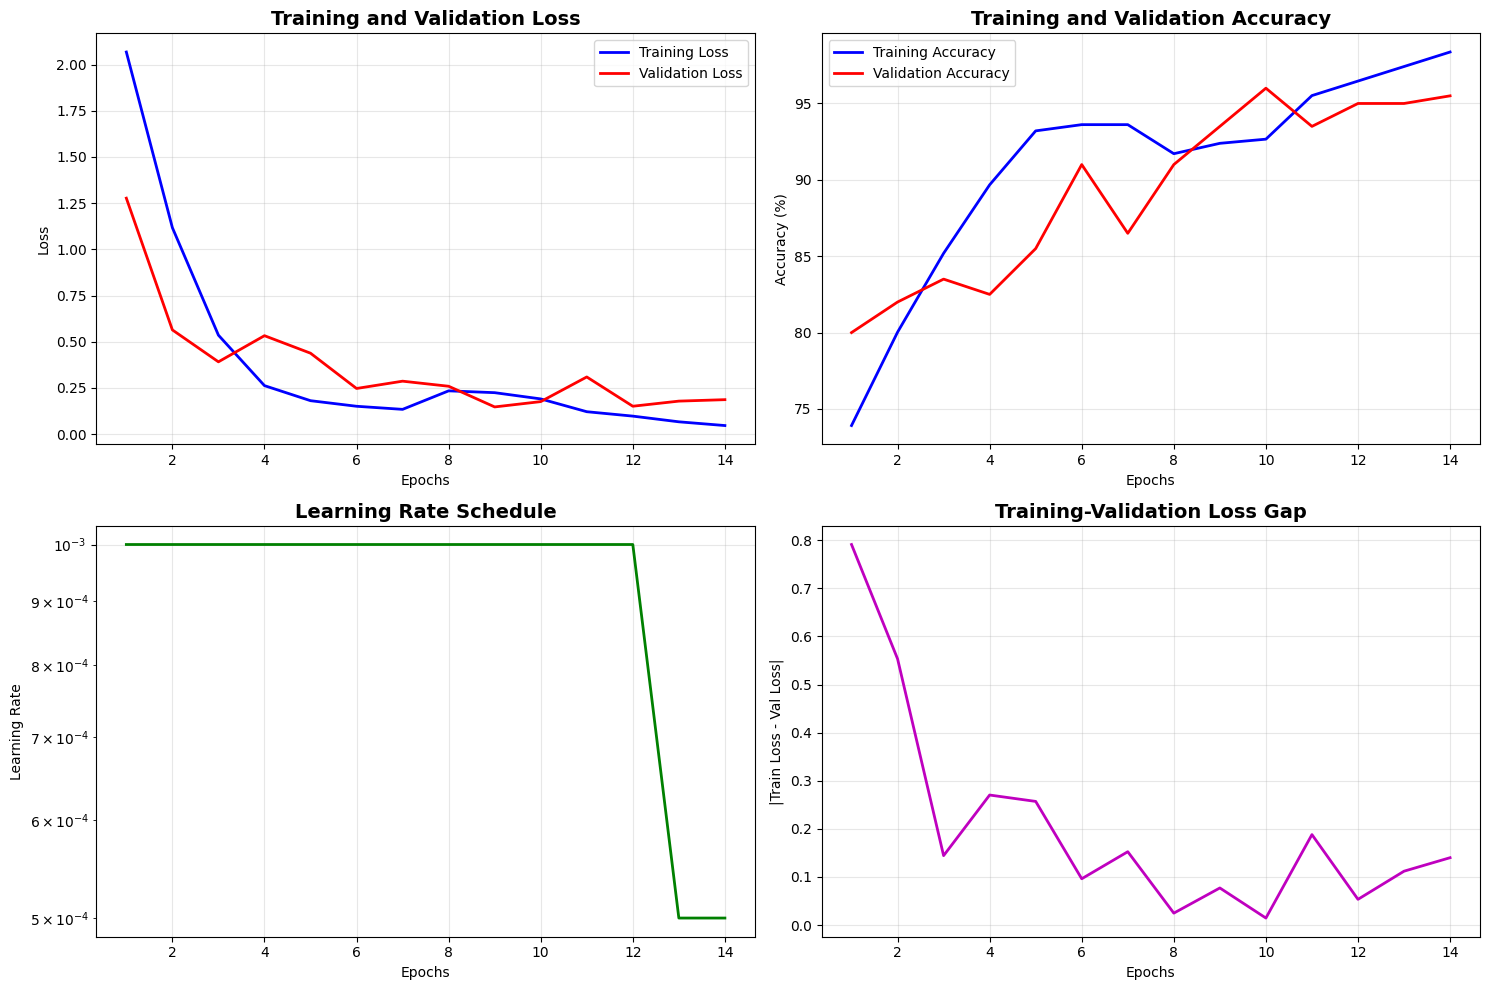

Plotting training history...


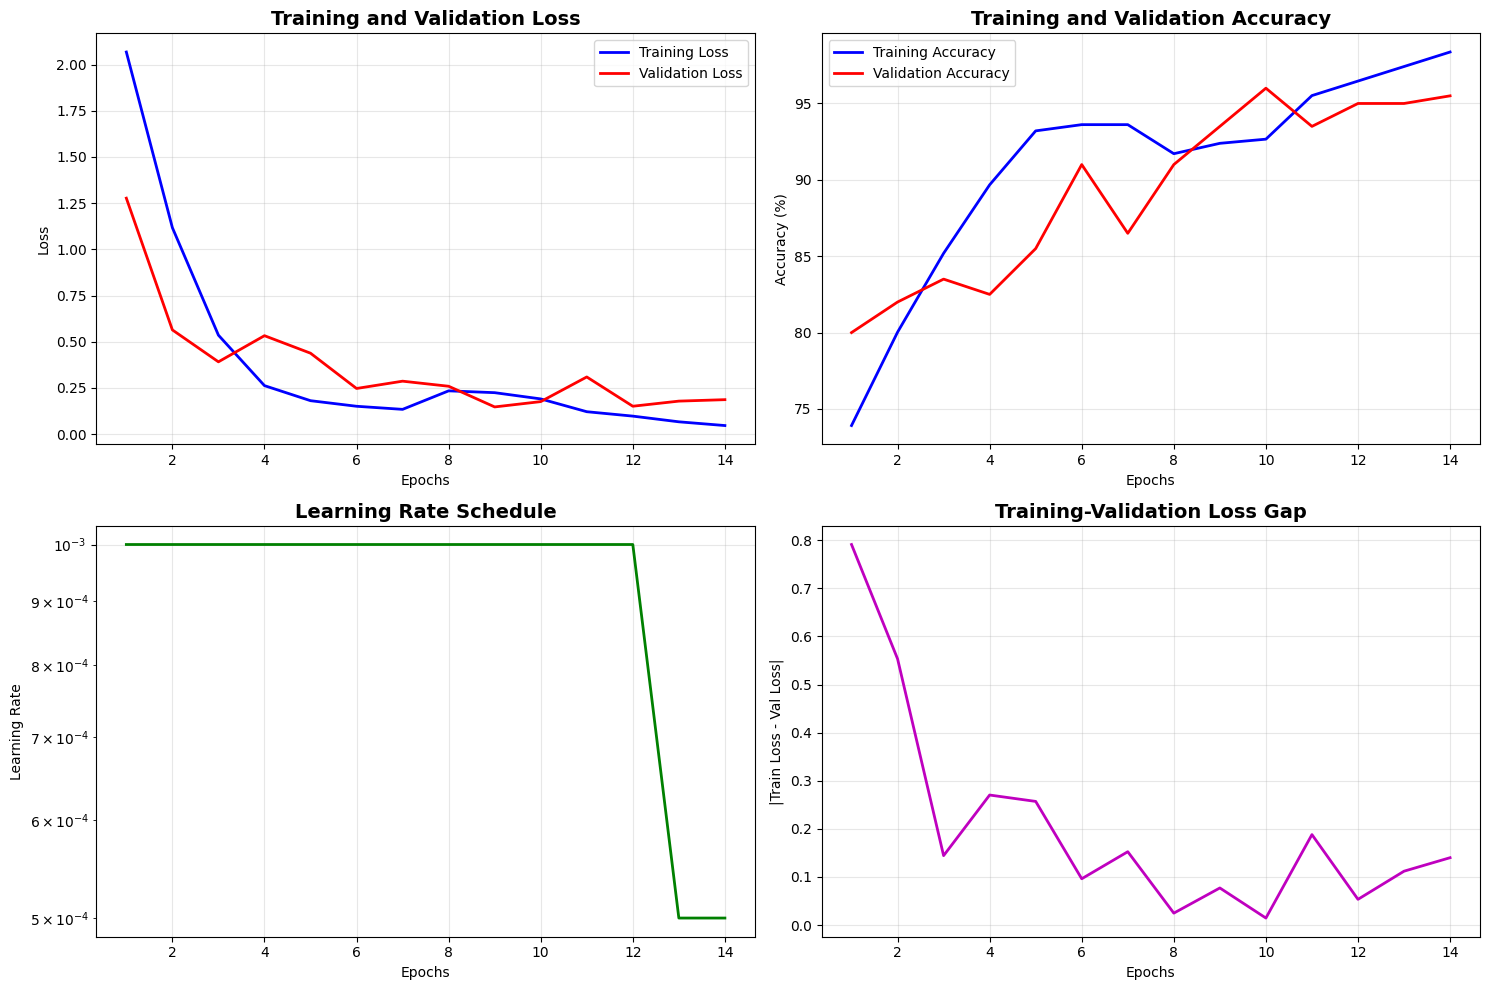

Loading best model for evaluation...
Best model metrics:
  Epoch: 9
  Train Loss: 0.2243
  Train Accuracy: 92.39%
  Val Loss: 0.1472
  Val Accuracy: 93.50%

Evaluating on test set...
Best model metrics:
  Epoch: 9
  Train Loss: 0.2243
  Train Accuracy: 92.39%
  Val Loss: 0.1472
  Val Accuracy: 93.50%

Evaluating on test set...


Plotting training history...


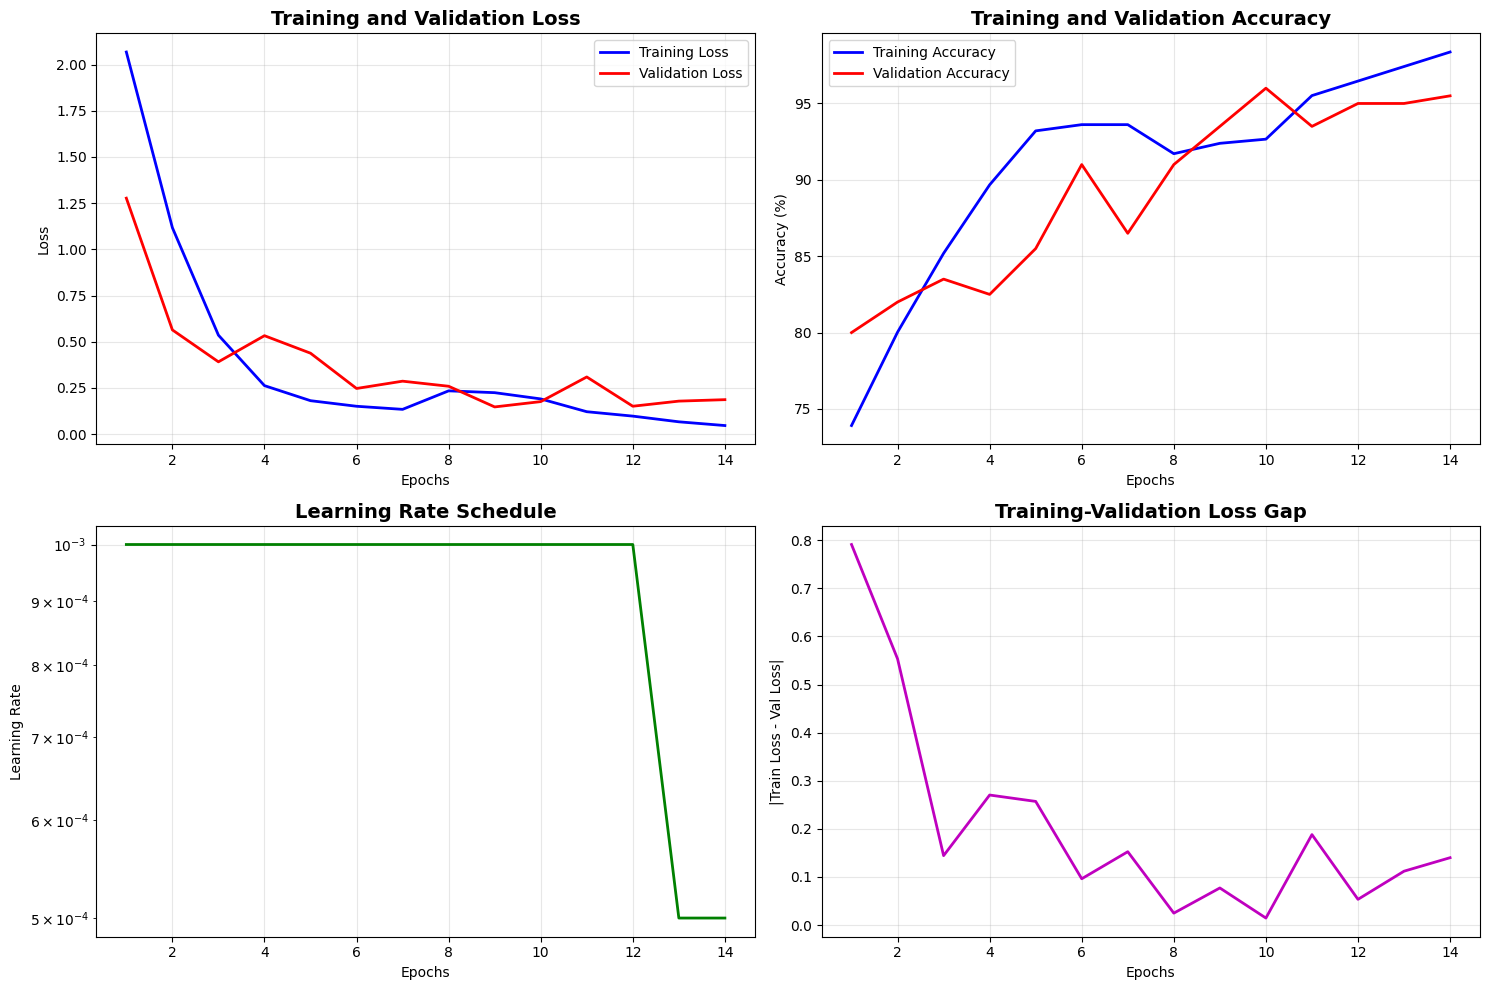

Loading best model for evaluation...
Best model metrics:
  Epoch: 9
  Train Loss: 0.2243
  Train Accuracy: 92.39%
  Val Loss: 0.1472
  Val Accuracy: 93.50%

Evaluating on test set...
Best model metrics:
  Epoch: 9
  Train Loss: 0.2243
  Train Accuracy: 92.39%
  Val Loss: 0.1472
  Val Accuracy: 93.50%

Evaluating on test set...


Testing: 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]



Plotting training history...


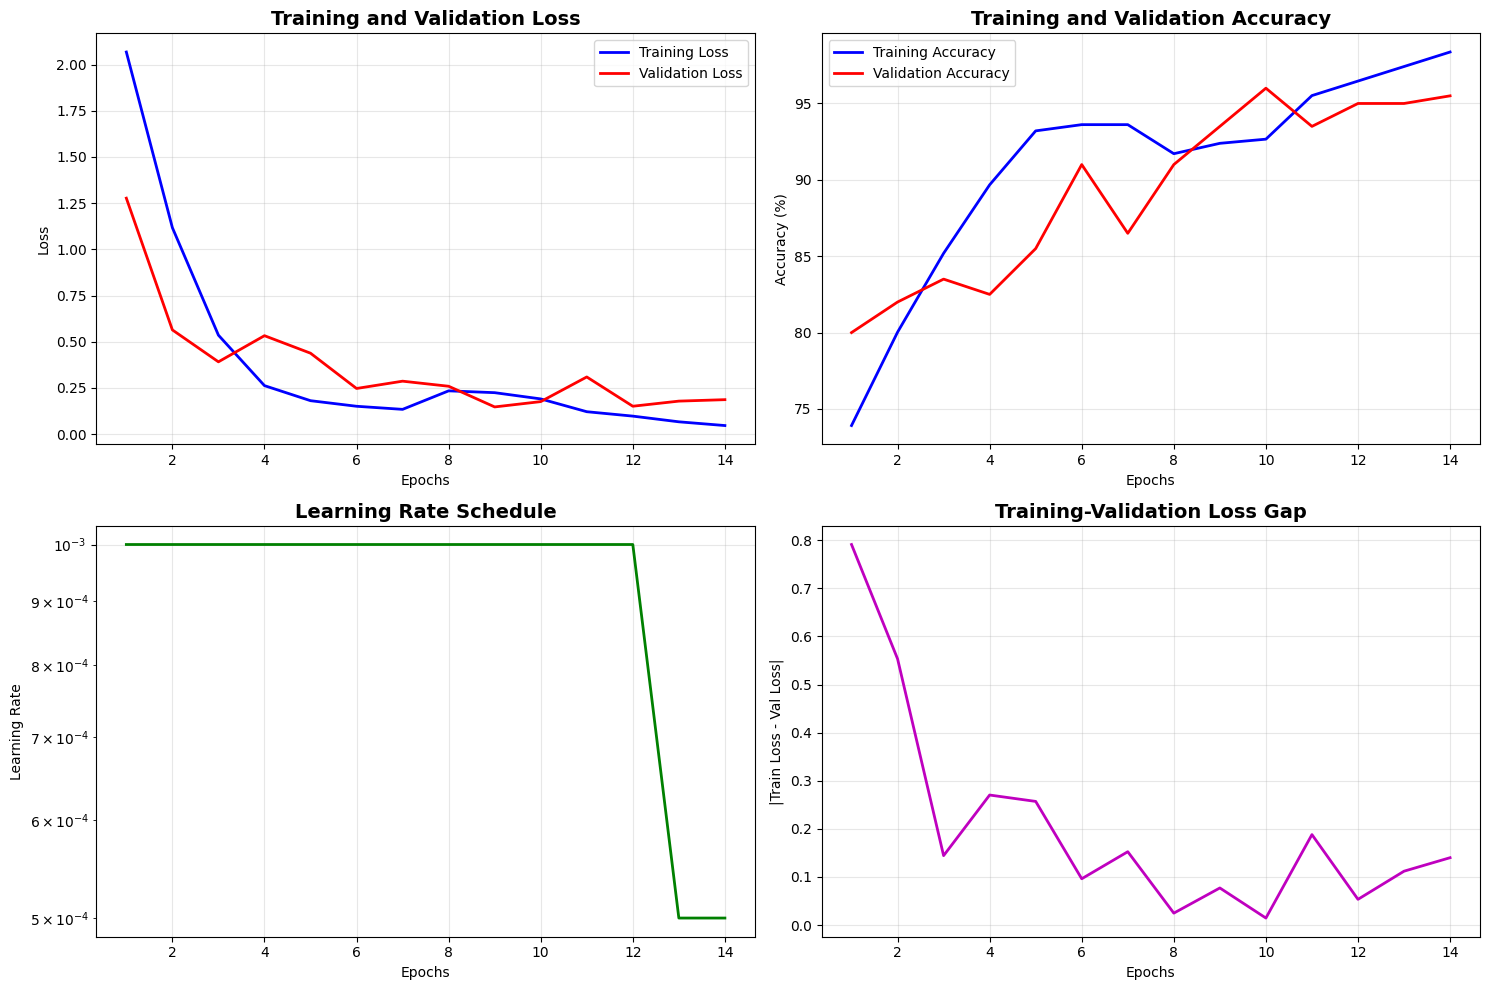

Loading best model for evaluation...
Best model metrics:
  Epoch: 9
  Train Loss: 0.2243
  Train Accuracy: 92.39%
  Val Loss: 0.1472
  Val Accuracy: 93.50%

Evaluating on test set...
Best model metrics:
  Epoch: 9
  Train Loss: 0.2243
  Train Accuracy: 92.39%
  Val Loss: 0.1472
  Val Accuracy: 93.50%

Evaluating on test set...


Testing: 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]



Test Results:
Test Loss: 0.5961
Test Accuracy: 78.00% (39/50)

Classification Report:
              precision    recall  f1-score   support

       COVID       0.72      0.92      0.81        25
      Normal       0.89      0.64      0.74        25

    accuracy                           0.78        50
   macro avg       0.80      0.78      0.78        50
weighted avg       0.80      0.78      0.78        50



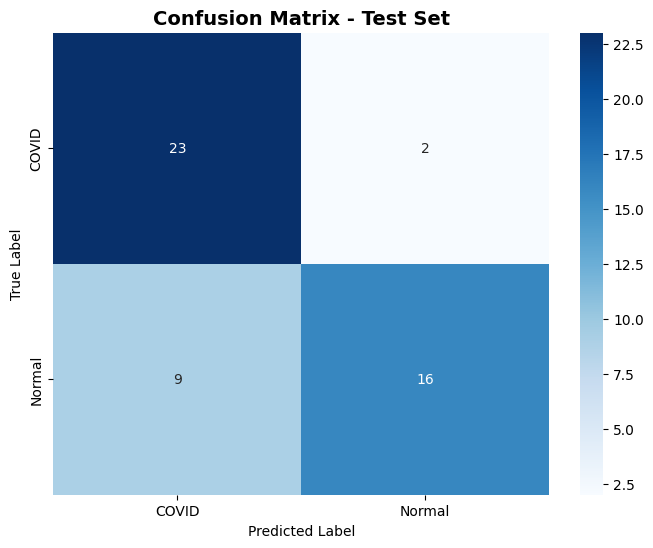

In [18]:
# Step 4: Training Visualization and Model Evaluation

def plot_training_history(history):
    """
    Plot training and validation metrics
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Learning rate plot
    ax3.plot(epochs, history['lr'], 'g-', linewidth=2)
    ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    
    # Loss difference plot
    loss_diff = [abs(t - v) for t, v in zip(history['train_loss'], history['val_loss'])]
    ax4.plot(epochs, loss_diff, 'm-', linewidth=2)
    ax4.set_title('Training-Validation Loss Gap', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('|Train Loss - Val Loss|')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, device):
    """
    Evaluate model on test set
    """
    model.eval()
    all_predictions = []
    all_labels = []
    test_loss = 0.0
    correct = 0
    total = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_accuracy = 100.0 * correct / total
    avg_test_loss = test_loss / len(test_loader)
    
    print(f"Test Results:")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}% ({correct}/{total})")
    
    return all_predictions, all_labels, test_accuracy, avg_test_loss

# Visualize training results (if training was completed)
if 'training_history' in locals():
    print("Plotting training history...")
    plot_training_history(training_history)
    
    # Load best model for evaluation
    if Path('e:/covid_19/best_covid_model.pth').exists():
        print("Loading best model for evaluation...")
        checkpoint = torch.load('e:/covid_19/best_covid_model.pth', map_location=device)
        trained_model.load_state_dict(checkpoint['model_state_dict'])
        
        print(f"Best model metrics:")
        print(f"  Epoch: {checkpoint['epoch']}")
        print(f"  Train Loss: {checkpoint['train_loss']:.4f}")
        print(f"  Train Accuracy: {checkpoint['train_acc']:.2f}%")
        print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
        print(f"  Val Accuracy: {checkpoint['val_acc']:.2f}%")
        
        # Evaluate on test set
        if 'test_loader' in locals():
            print("\nEvaluating on test set...")
            predictions, true_labels, test_acc, test_loss = evaluate_model(
                trained_model, test_loader, device
            )
            
            # Classification report
            from sklearn.metrics import classification_report, confusion_matrix
            class_names = ['COVID', 'Normal']
            
            print("\nClassification Report:")
            print(classification_report(true_labels, predictions, target_names=class_names))
            
            # Confusion Matrix
            cm = confusion_matrix(true_labels, predictions)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=class_names, yticklabels=class_names)
            plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
    
else:
    print("Training history not available - model training may not have completed.")

🚀 Starting comprehensive model evaluation...
Created EfficientNet-B0 model with 2 classes
✓ Best model loaded from e:/covid_19/best_covid_model.pth
  - Trained for 9 epochs
  - Best validation loss: 0.1472
  - Best validation accuracy: 93.50%
COMPREHENSIVE MODEL EVALUATION ON TEST SET
Evaluating model on test set...
✓ Best model loaded from e:/covid_19/best_covid_model.pth
  - Trained for 9 epochs
  - Best validation loss: 0.1472
  - Best validation accuracy: 93.50%
COMPREHENSIVE MODEL EVALUATION ON TEST SET
Evaluating model on test set...


Testing: 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]




📊 OVERALL TEST RESULTS:
Test Loss: 0.5961
Test Accuracy: 78.00% (39/50)

📋 DETAILED CLASSIFICATION REPORT:
--------------------------------------------------
              precision    recall  f1-score   support

       COVID     0.7188    0.9200    0.8070        25
      NORMAL     0.8889    0.6400    0.7442        25

    accuracy                         0.7800        50
   macro avg     0.8038    0.7800    0.7756        50
weighted avg     0.8038    0.7800    0.7756        50


📈 PER-CLASS DETAILED METRICS:
----------------------------------------
COVID:
  Precision: 0.7188
  Recall: 0.9200
  F1-Score: 0.8070
  Support: 25

NORMAL:
  Precision: 0.8889
  Recall: 0.6400
  F1-Score: 0.7442
  Support: 25



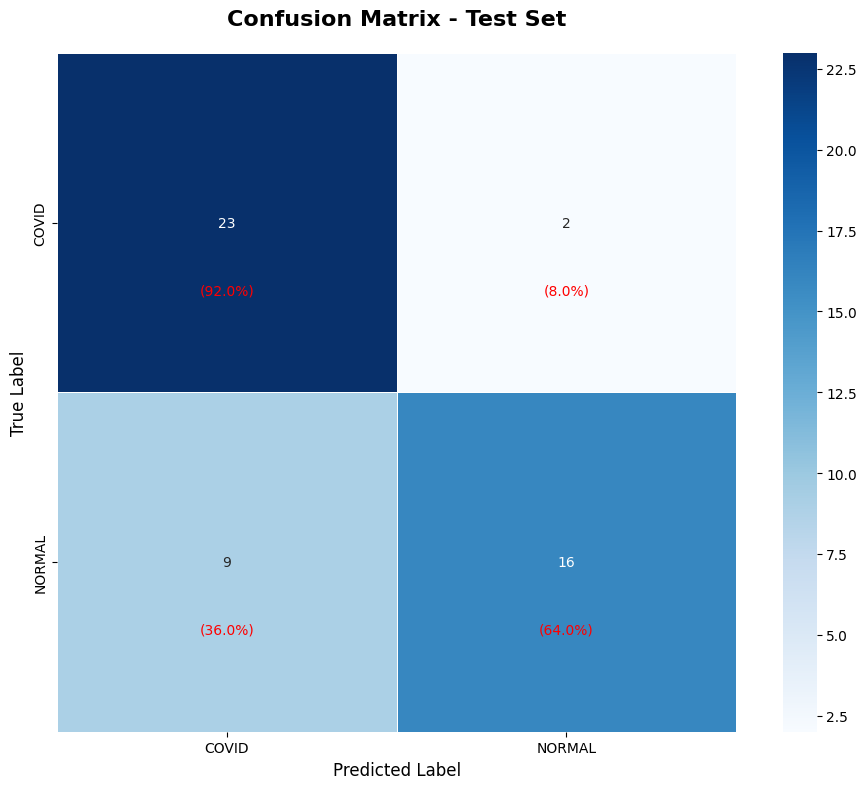


🖼️  Visualizing test predictions...


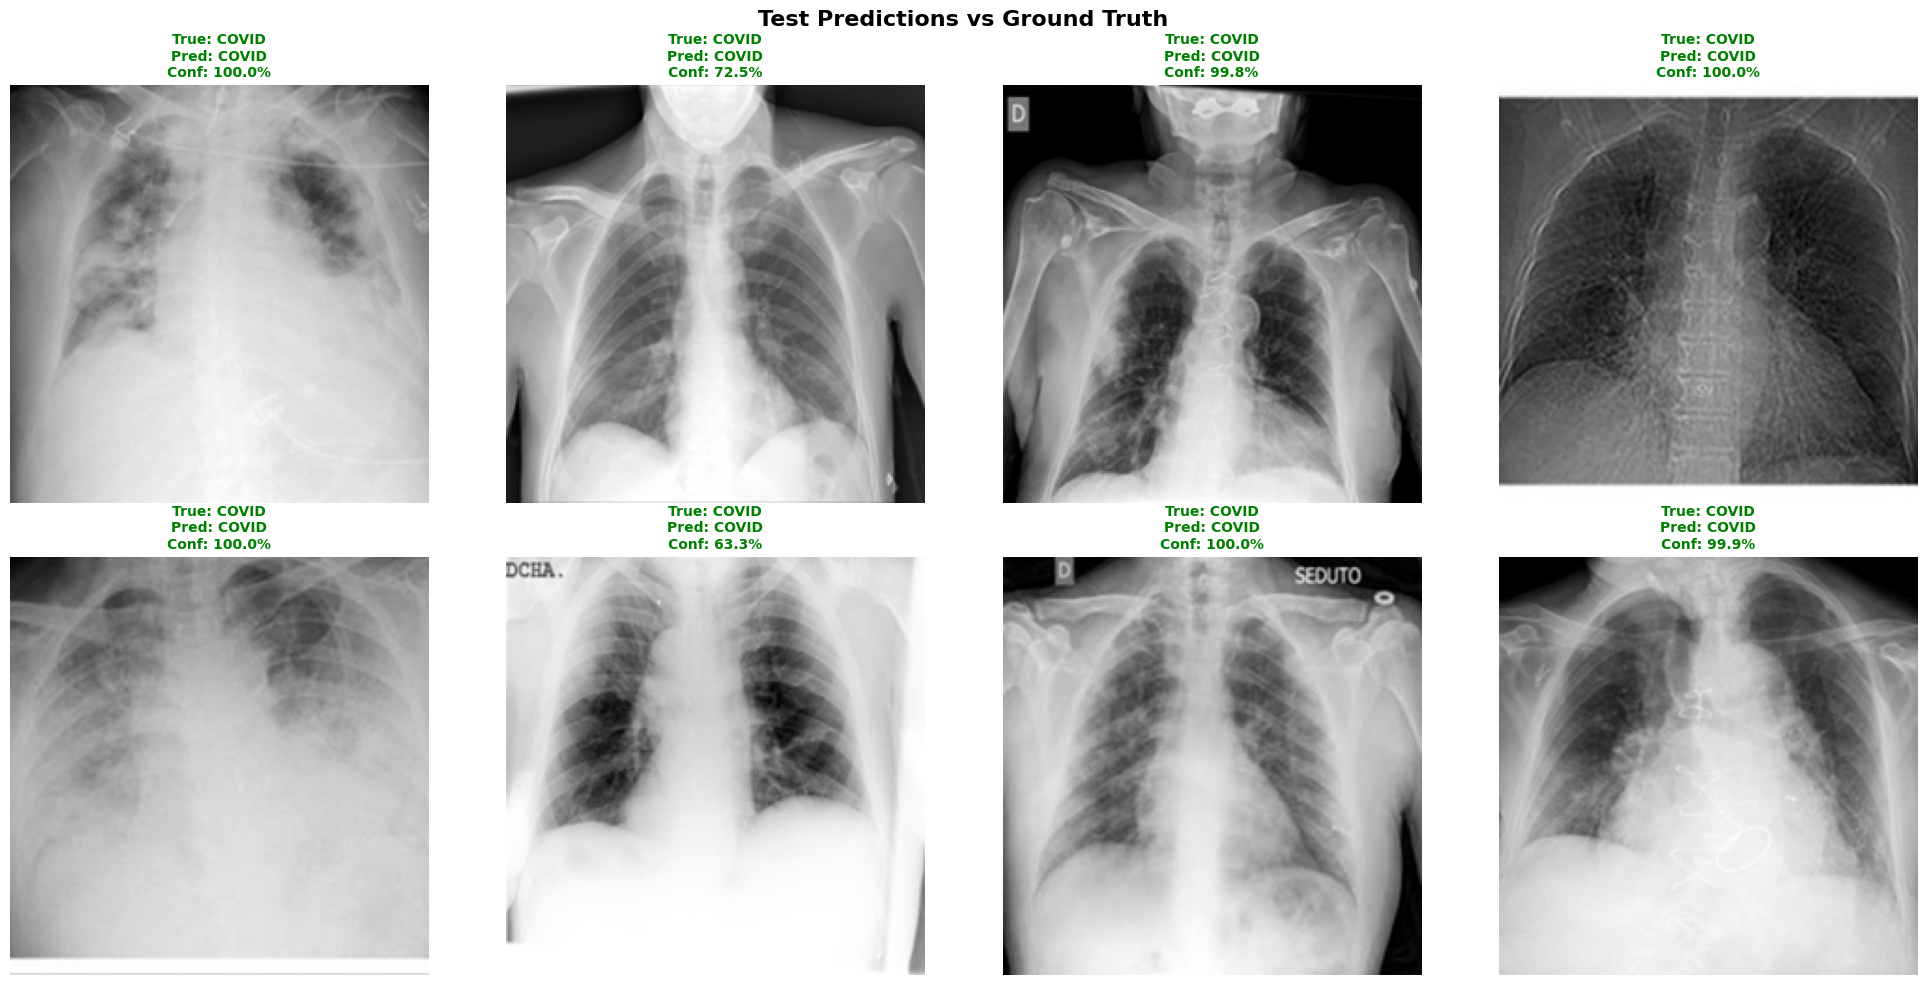


🔍 ERROR ANALYSIS:
------------------------------
Total misclassified samples: 11

Top 5 most confident wrong predictions:
  1. True: NORMAL, Predicted: COVID
     Confidence: 99.01%
     Probabilities: COVID=99.0%, Normal=1.0%

  2. True: NORMAL, Predicted: COVID
     Confidence: 97.44%
     Probabilities: COVID=97.4%, Normal=2.6%

  3. True: NORMAL, Predicted: COVID
     Confidence: 95.40%
     Probabilities: COVID=95.4%, Normal=4.6%

  4. True: NORMAL, Predicted: COVID
     Confidence: 93.56%
     Probabilities: COVID=93.6%, Normal=6.4%

  5. True: NORMAL, Predicted: COVID
     Confidence: 81.31%
     Probabilities: COVID=81.3%, Normal=18.7%


✅ Model evaluation completed!
Final Test Accuracy: 78.00%


In [ ]:
# Step 5: Comprehensive Model Evaluation

def load_best_model(model_path, model_architecture='efficientnet_b0', num_classes=2, device='cpu'):
    '''
    Load the best saved model from checkpoint.
    '''
    from pathlib import Path
    if not Path(model_path).exists():
        print(f"Error: Model file {model_path} not found!")
        return None, None
    
    # Create model architecture
    import timm
    if model_architecture == 'efficientnet_b0':
        model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=num_classes)
    elif model_architecture == 'resnet50':
        from torchvision import models
        model = models.resnet50(pretrained=False)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    else:
        raise ValueError(f"Unsupported model: {model_architecture}")
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"✓ Best model loaded from {model_path}")
    print(f"  - Trained for {checkpoint['epoch']} epochs")
    print(f"  - Best validation loss: {checkpoint['val_loss']:.4f}")
    print(f"  - Best validation accuracy: {checkpoint['val_acc']:.2f}%")
    
    return model, checkpoint

def comprehensive_test_evaluation(model, test_loader, device, class_names=['COVID', 'Normal']):
    """
    Comprehensive evaluation of the model on test dataset
    """
    print("="*60)
    print("COMPREHENSIVE MODEL EVALUATION ON TEST SET")
    print("="*60)
    
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    test_loss = 0.0
    correct = 0
    total = 0
    
    criterion = nn.CrossEntropyLoss()
    
    print("Evaluating model on test set...")
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="Testing")):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            # Get predictions and probabilities
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            # Collect results
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate metrics
    test_accuracy = 100.0 * correct / total
    avg_test_loss = test_loss / len(test_loader)
    
    print(f"\n📊 OVERALL TEST RESULTS:")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}% ({correct}/{total})")
    
    # Detailed classification metrics
    from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
    
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    print("-" * 50)
    print(classification_report(all_labels, all_predictions, target_names=class_names, digits=4))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_predictions, average=None)
    
    print(f"\n📈 PER-CLASS DETAILED METRICS:")
    print("-" * 40)
    for i, class_name in enumerate(class_names):
        print(f"{class_name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1[i]:.4f}")
        print(f"  Support: {support[i]}")
        print()
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=class_names, yticklabels=class_names,
               square=True, linewidths=0.5)
    plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    
    # Add percentage annotations
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j+0.5, i+0.7, f'({cm_percent[i,j]:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='red')
    
    plt.tight_layout()
    plt.show()
    
    return all_predictions, all_labels, all_probabilities, test_accuracy, avg_test_loss

def visualize_test_predictions(model, test_loader, device, class_names=['COVID', 'Normal'], num_samples=8):
    """
    Visualize test predictions with actual vs predicted labels
    """
    model.eval()
    
    # Get a batch of test images
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    # Select samples to display
    num_samples = min(num_samples, len(images))
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Test Predictions vs Ground Truth', fontsize=16, fontweight='bold')
    
    for i in range(num_samples):
        row = i // 4
        col = i % 4
        
        # Denormalize and convert to displayable format
        img = denormalize_tensor(images[i].cpu())
        img = torch.clamp(img, 0, 1)
        img_np = img.permute(1, 2, 0).numpy()
        
        # Convert to grayscale for X-ray images
        if img_np.shape[2] == 3:
            img_np = np.mean(img_np, axis=2)
        
        axes[row, col].imshow(img_np, cmap='gray')
        
        # Get prediction info
        true_label = class_names[labels[i].cpu().item()]
        pred_label = class_names[predicted[i].cpu().item()]
        confidence = probabilities[i].max().cpu().item() * 100
        
        # Color code: green for correct, red for incorrect
        color = 'green' if labels[i] == predicted[i] else 'red'
        
        title = f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%'
        axes[row, col].set_title(title, fontsize=10, color=color, fontweight='bold')
        axes[row, col].axis('off')
    
    # Hide empty subplots
    for i in range(num_samples, 8):
        row = i // 4
        col = i % 4
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_model_errors(all_labels, all_predictions, all_probabilities, class_names=['COVID', 'Normal']):
    """
    Analyze and display model errors and edge cases
    """
    print("\n🔍 ERROR ANALYSIS:")
    print("-" * 30)
    
    # Find misclassified samples
    misclassified = []
    for i, (true_label, pred_label, probs) in enumerate(zip(all_labels, all_predictions, all_probabilities)):
        if true_label != pred_label:
            confidence = max(probs) * 100
            misclassified.append({
                'index': i,
                'true_class': class_names[true_label],
                'predicted_class': class_names[pred_label],
                'confidence': confidence,
                'probabilities': probs
            })
    
    print(f"Total misclassified samples: {len(misclassified)}")
    
    if misclassified:
        # Sort by confidence (most confident wrong predictions first)
        misclassified.sort(key=lambda x: x['confidence'], reverse=True)
        
        print(f"\nTop 5 most confident wrong predictions:")
        for i, error in enumerate(misclassified[:5]):
            print(f"  {i+1}. True: {error['true_class']}, Predicted: {error['predicted_class']}")
            print(f"     Confidence: {error['confidence']:.2f}%")
            print(f"     Probabilities: COVID={error['probabilities'][0]*100:.1f}%, Normal={error['probabilities'][1]*100:.1f}%")
            print()

# Execute comprehensive evaluation if model and data are available
if 'trained_model' in locals() and 'test_loader' in locals():
    print("🚀 Starting comprehensive model evaluation...")
    
    # Load the best model
    best_model, checkpoint_info = load_best_model(
        model_path='e:/covid_19/best_covid_model.pth',
        model_architecture='efficientnet_b0',
        num_classes=2,
        device=device
    )
    
    if best_model is not None:
        # Get class names
        if 'train_dataset' in locals():
            class_names = [name.upper() for name in train_dataset.classes]
        else:
            class_names = ['COVID', 'NORMAL']
        
        # Comprehensive evaluation
        predictions, true_labels, probabilities, test_acc, test_loss = comprehensive_test_evaluation(
            best_model, test_loader, device, class_names
        )
        
        # Visualize predictions
        print("\n🖼️  Visualizing test predictions...")
        visualize_test_predictions(best_model, test_loader, device, class_names, num_samples=8)
        
        # Error analysis
        analyze_model_errors(true_labels, predictions, probabilities, class_names)
        
        print("\n✅ Model evaluation completed!")
        print(f"Final Test Accuracy: {test_acc:.2f}%")
        
    else:
        print("❌ Could not load the best model for evaluation.")

elif Path('e:/covid_19/best_covid_model.pth').exists() and 'test_loader' in locals():
    print("🔄 Loading saved model for evaluation...")
    
    # Load model even if training wasn't run in this session
    best_model, checkpoint_info = load_best_model(
        model_path='e:/covid_19/best_covid_model.pth',
        model_architecture='efficientnet_b0',
        num_classes=2,
        device=device
    )
    
    if best_model is not None:
        class_names = ['COVID', 'NORMAL']
        
        predictions, true_labels, probabilities, test_acc, test_loss = comprehensive_test_evaluation(
            best_model, test_loader, device, class_names
        )
        
        visualize_test_predictions(best_model, test_loader, device, class_names, num_samples=8)
        analyze_model_errors(true_labels, predictions, probabilities, class_names)
        
        print(f"\n✅ Evaluation completed! Final Test Accuracy: {test_acc:.2f}%")

else:
    print("❌ Cannot perform evaluation - missing model or test data.")
    if not Path('e:/covid_19/best_covid_model.pth').exists():
        print("   - No saved model found at 'e:/covid_19/best_covid_model.pth'")
    if 'test_loader' not in locals():
        print("   - Test data loader not available")

In [4]:
# Step 6: Enhanced Test Data Pipeline

def enhance_test_image_quality(image):
    """
    Enhanced image quality pipeline specifically for test images
    Applies contrast and sharpness improvements for better model evaluation
    """
    try:
        # Apply contrast enhancement (factor 1.3-1.5)
        contrast_enhancer = ImageEnhance.Contrast(image)
        contrast_factor = random.uniform(1.3, 1.5)
        image = contrast_enhancer.enhance(contrast_factor)
        
        # Apply sharpness enhancement (factor 1.5-2.0)
        sharpness_enhancer = ImageEnhance.Sharpness(image)
        sharpness_factor = random.uniform(1.5, 2.0)
        image = sharpness_enhancer.enhance(sharpness_factor)
        
        return image
        
    except Exception as e:
        print(f"Warning: Test enhancement failed for image, using original: {e}")
        return image

# Enhanced test transforms pipeline
enhanced_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # Enhanced image quality for better test evaluation
    transforms.Lambda(enhance_test_image_quality),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

def create_enhanced_test_dataset(test_path, enhanced_transforms):
    """
    Create enhanced test dataset with improved image quality
    """
    if not test_path.exists():
        print(f"Warning: Enhanced test path {test_path} does not exist!")
        return None
    
    # Check if class folders exist
    covid_path = test_path / 'covid'
    normal_path = test_path / 'normal'
    if not covid_path.exists() or not normal_path.exists():
        print(f"Warning: Missing covid or normal folders in {test_path}")
        return None
    
    # Create enhanced test dataset
    enhanced_test_dataset = datasets.ImageFolder(root=test_path, transform=enhanced_transforms)
    
    print("Enhanced Test Dataset Information:")
    print(f"Enhanced test samples: {len(enhanced_test_dataset)}")
    print(f"Number of classes: {len(enhanced_test_dataset.classes)}")
    print(f"Class names: {enhanced_test_dataset.classes}")
    print(f"Class to index mapping: {enhanced_test_dataset.class_to_idx}")
    
    # Count samples per class
    class_counts = defaultdict(int)
    for _, label in enhanced_test_dataset:
        class_name = enhanced_test_dataset.classes[label]
        class_counts[class_name] += 1
    
    print(f"\nEnhanced test class distribution:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} samples")
    
    return enhanced_test_dataset

def create_enhanced_test_dataloader(enhanced_test_dataset, batch_size=32, num_workers=0):
    """
    Create DataLoader for enhanced test dataset
    """
    enhanced_test_loader = DataLoader(
        enhanced_test_dataset,
        batch_size=batch_size,
        shuffle=False,  # Don't shuffle test data
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    
    print(f"\nEnhanced Test DataLoader created:")
    print(f"Batch size: {batch_size}")
    print(f"Enhanced test batches: {len(enhanced_test_loader)}")
    
    return enhanced_test_loader

def compare_test_pipelines(original_loader, enhanced_loader):
    """
    Compare original and enhanced test data pipelines
    """
    print("\n" + "="*60)
    print("COMPARISON: ORIGINAL vs ENHANCED TEST PIPELINES")
    print("="*60)
    
    # Get sample batches from both loaders
    try:
        orig_images, orig_labels = next(iter(original_loader))
        enhanced_images, enhanced_labels = next(iter(enhanced_loader))
        
        print(f"\n📊 BATCH COMPARISON:")
        print(f"Original test batch shape: {orig_images.shape}")
        print(f"Enhanced test batch shape: {enhanced_images.shape}")
        print(f"Original labels: {orig_labels[:8].tolist()}")
        print(f"Enhanced labels: {enhanced_labels[:8].tolist()}")
        
        print(f"\n📈 TENSOR STATISTICS:")
        print(f"Original image range: [{orig_images.min():.3f}, {orig_images.max():.3f}]")
        print(f"Enhanced image range: [{enhanced_images.min():.3f}, {enhanced_images.max():.3f}]")
        print(f"Original mean: {orig_images.mean():.3f}, std: {orig_images.std():.3f}")
        print(f"Enhanced mean: {enhanced_images.mean():.3f}, std: {enhanced_images.std():.3f}")
        
        # Visualize comparison
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        fig.suptitle('Original vs Enhanced Test Images', fontsize=16, fontweight='bold')
        
        for i in range(4):
            # Original images (top row)
            orig_img = denormalize_tensor(orig_images[i])
            orig_img = torch.clamp(orig_img, 0, 1)
            orig_img_np = orig_img.permute(1, 2, 0).numpy()
            if orig_img_np.shape[2] == 3:
                orig_img_np = np.mean(orig_img_np, axis=2)
            
            axes[0, i].imshow(orig_img_np, cmap='gray')
            axes[0, i].set_title(f'Original\nClass: {["COVID", "Normal"][orig_labels[i]]}', fontsize=10)
            axes[0, i].axis('off')
            
            # Enhanced images (bottom row)
            enh_img = denormalize_tensor(enhanced_images[i])
            enh_img = torch.clamp(enh_img, 0, 1)
            enh_img_np = enh_img.permute(1, 2, 0).numpy()
            if enh_img_np.shape[2] == 3:
                enh_img_np = np.mean(enh_img_np, axis=2)
            
            axes[1, i].imshow(enh_img_np, cmap='gray')
            axes[1, i].set_title(f'Enhanced\nClass: {["COVID", "Normal"][enhanced_labels[i]]}', fontsize=10)
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return True
        
    except Exception as e:
        print(f"Error comparing pipelines: {e}")
        return False

# Create enhanced test pipeline if original test data exists
if test_dataset is not None and 'test_loader' in locals():
    print("🔧 Creating enhanced test data pipeline...")
    
    # Create enhanced test dataset
    enhanced_test_dataset = create_enhanced_test_dataset(test_path, enhanced_test_transforms)
    
    if enhanced_test_dataset is not None:
        # Create enhanced test DataLoader
        enhanced_test_loader = create_enhanced_test_dataloader(
            enhanced_test_dataset, 
            batch_size=32, 
            num_workers=0
        )
        
        # Verify enhanced test pipeline
        try:
            enhanced_sample_batch = next(iter(enhanced_test_loader))
            enhanced_images, enhanced_labels = enhanced_sample_batch
            
            print(f"\n✅ ENHANCED TEST PIPELINE VERIFICATION:")
            print(f"Enhanced images shape: {enhanced_images.shape}")
            print(f"Enhanced labels shape: {enhanced_labels.shape}")
            print(f"Enhanced image tensor range: [{enhanced_images.min():.3f}, {enhanced_images.max():.3f}]")
            print(f"Enhanced sample labels: {enhanced_labels[:10].tolist()}")
            
            # Get class names for reference
            if 'train_dataset' in locals():
                enhanced_class_names = train_dataset.classes
            else:
                enhanced_class_names = enhanced_test_dataset.classes
            print(f"Enhanced class mapping: {dict(enumerate(enhanced_class_names))}")
            
            # Compare with original test pipeline
            comparison_success = compare_test_pipelines(test_loader, enhanced_test_loader)
            
            if comparison_success:
                print(f"\n🎯 ENHANCED TEST PIPELINE READY!")
                print(f"   - Original test samples: {len(test_dataset)}")
                print(f"   - Enhanced test samples: {len(enhanced_test_dataset)}")
                print(f"   - Both pipelines use the same data with different preprocessing")
                print(f"   - Enhanced pipeline includes contrast (1.3-1.5x) and sharpness (1.5-2.0x) improvements")
            
        except Exception as e:
            print(f"Error verifying enhanced test pipeline: {e}")
            enhanced_test_loader = None
    
    else:
        print("❌ Failed to create enhanced test dataset")
        enhanced_test_loader = None

else:
    print("❌ Cannot create enhanced test pipeline - original test data not available")
    enhanced_test_loader = None

# Summary of available test pipelines
print("\n" + "="*50)
print("AVAILABLE TEST PIPELINES SUMMARY")
print("="*50)

if 'test_loader' in locals():
    print("✅ Original Test Pipeline: Available")
    print("   - Standard preprocessing (resize + normalize)")
    print("   - Used for standard model evaluation")
else:
    print("❌ Original Test Pipeline: Not available")

if 'enhanced_test_loader' in locals() and enhanced_test_loader is not None:
    print("✅ Enhanced Test Pipeline: Available")
    print("   - Enhanced preprocessing (resize + contrast/sharpness boost + normalize)")
    print("   - Used for improved model evaluation with better image quality")
else:
    print("❌ Enhanced Test Pipeline: Not available")

NameError: name 'IMG_SIZE' is not defined

In [ ]:
# Step 7: Enhanced Test Evaluation with Best Model

def evaluate_model_on_enhanced_test(model_path='e:/covid_19/best_covid_model.pth', 
                                   enhanced_test_loader=None, 
                                   device='cpu',
                                   model_architecture='efficientnet_b0',
                                   num_classes=2):
    """
    Evaluate the saved best COVID classification model on enhanced test images
    """
    print("🔬 EVALUATING BEST MODEL ON ENHANCED TEST IMAGES")
    print("="*60)
    
    # Check if enhanced test loader is available
    if enhanced_test_loader is None:
        print("❌ Enhanced test loader not available!")
        return None
    
    # Load the best model
    print("📂 Loading saved model...")
    best_model, checkpoint_info = load_best_model(
        model_path=model_path,
        model_architecture=model_architecture,
        num_classes=num_classes,
        device=device
    )
    
    if best_model is None:
        print("❌ Failed to load model!")
        return None
    
    # Set model to evaluation mode
    best_model.eval()
    
    # Initialize tracking variables
    all_predictions = []
    all_labels = []
    all_probabilities = []
    test_loss = 0.0
    correct = 0
    total = 0
    
    criterion = nn.CrossEntropyLoss()
    
    print("\n🧪 Evaluating on enhanced test data...")
    
    # Evaluation loop
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(enhanced_test_loader, desc="Enhanced Testing")):
            # Move data to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = best_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            # Get predictions and probabilities
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            # Collect results
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate final metrics
    test_accuracy = 100.0 * correct / total
    avg_test_loss = test_loss / len(enhanced_test_loader)
    
    print(f"\n📊 ENHANCED TEST RESULTS:")
    print(f"Enhanced Test Loss: {avg_test_loss:.4f}")
    print(f"Enhanced Test Accuracy: {test_accuracy:.2f}% ({correct}/{total})")
    
    # Get class names
    if 'train_dataset' in globals():
        class_names = [name.upper() for name in train_dataset.classes]
    else:
        class_names = ['COVID', 'NORMAL']
    
    # Detailed classification metrics
    from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
    
    print(f"\n📋 ENHANCED TEST CLASSIFICATION REPORT:")
    print("-" * 55)
    print(classification_report(all_labels, all_predictions, target_names=class_names, digits=4))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_predictions, average=None)
    
    print(f"\n📈 ENHANCED TEST PER-CLASS METRICS:")
    print("-" * 45)
    for i, class_name in enumerate(class_names):
        print(f"{class_name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1[i]:.4f}")
        print(f"  Support: {support[i]}")
        print()
    
    # Enhanced Test Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
               xticklabels=class_names, yticklabels=class_names,
               square=True, linewidths=0.5)
    plt.title('Confusion Matrix - Enhanced Test Set', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    
    # Add percentage annotations
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j+0.5, i+0.7, f'({cm_percent[i,j]:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='darkgreen')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'predictions': all_predictions,
        'labels': all_labels, 
        'probabilities': all_probabilities,
        'accuracy': test_accuracy,
        'loss': avg_test_loss,
        'confusion_matrix': cm,
        'class_names': class_names
    }

def compare_original_vs_enhanced_performance():
    """
    Compare model performance on original vs enhanced test data
    """
    print("\n" + "🆚" * 30)
    print("PERFORMANCE COMPARISON: ORIGINAL vs ENHANCED TEST")
    print("🆚" * 30)
    
    results = {}
    
    # Evaluate on original test data if available
    if 'test_loader' in globals() and Path('e:/covid_19/best_covid_model.pth').exists():
        print("\n🔄 Evaluating on ORIGINAL test data...")
        
        # Load model for original evaluation
        orig_model, _ = load_best_model(
            model_path='e:/covid_19/best_covid_model.pth',
            model_architecture='efficientnet_b0',
            num_classes=2,
            device=device
        )
        
        if orig_model is not None:
            # Quick evaluation on original test data
            orig_model.eval()
            orig_correct = 0
            orig_total = 0
            orig_loss = 0.0
            criterion = nn.CrossEntropyLoss()
            
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = orig_model(images)
                    loss = criterion(outputs, labels)
                    orig_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    orig_total += labels.size(0)
                    orig_correct += (predicted == labels).sum().item()
            
            orig_accuracy = 100.0 * orig_correct / orig_total
            orig_avg_loss = orig_loss / len(test_loader)
            
            results['original'] = {
                'accuracy': orig_accuracy,
                'loss': orig_avg_loss,
                'total_samples': orig_total
            }
            
            print(f"✅ Original Test Results:")
            print(f"   Accuracy: {orig_accuracy:.2f}%")
            print(f"   Loss: {orig_avg_loss:.4f}")
    
    # Evaluate on enhanced test data
    if 'enhanced_test_loader' in globals() and enhanced_test_loader is not None:
        print(f"\n🔄 Evaluating on ENHANCED test data...")
        enhanced_results = evaluate_model_on_enhanced_test(
            enhanced_test_loader=enhanced_test_loader,
            device=device
        )
        
        if enhanced_results is not None:
            results['enhanced'] = {
                'accuracy': enhanced_results['accuracy'],
                'loss': enhanced_results['loss'],
                'total_samples': len(enhanced_results['labels'])
            }
    
    # Display comparison
    if 'original' in results and 'enhanced' in results:
        print(f"\n📊 COMPARISON SUMMARY:")
        print(f"{'='*50}")
        print(f"{'Metric':<20} {'Original':<15} {'Enhanced':<15} {'Improvement':<15}")
        print(f"{'='*50}")
        
        orig_acc = results['original']['accuracy']
        enh_acc = results['enhanced']['accuracy']
        acc_improvement = enh_acc - orig_acc
        
        orig_loss = results['original']['loss']
        enh_loss = results['enhanced']['loss']
        loss_improvement = orig_loss - enh_loss  # Lower loss is better
        
        print(f"{'Accuracy (%)':<20} {orig_acc:<15.2f} {enh_acc:<15.2f} {acc_improvement:<+15.2f}")
        print(f"{'Loss':<20} {orig_loss:<15.4f} {enh_loss:<15.4f} {loss_improvement:<+15.4f}")
        print(f"{'='*50}")
        
        # Interpretation
        if acc_improvement > 0:
            print(f"🎉 Enhanced preprocessing IMPROVED accuracy by {acc_improvement:.2f}%!")
        elif acc_improvement < -0.5:
            print(f"⚠️  Enhanced preprocessing DECREASED accuracy by {abs(acc_improvement):.2f}%")
        else:
            print(f"➖ Enhanced preprocessing had minimal impact on accuracy ({acc_improvement:+.2f}%)")
        
        if loss_improvement > 0:
            print(f"🎉 Enhanced preprocessing IMPROVED loss by {loss_improvement:.4f}!")
        elif loss_improvement < -0.01:
            print(f"⚠️  Enhanced preprocessing INCREASED loss by {abs(loss_improvement):.4f}")
        else:
            print(f"➖ Enhanced preprocessing had minimal impact on loss ({loss_improvement:+.4f})")
    
    else:
        print("❌ Cannot perform comparison - missing original or enhanced results")
    
    return results

# Execute enhanced test evaluation if enhanced test loader is available
if 'enhanced_test_loader' in globals() and enhanced_test_loader is not None:
    print("🚀 Starting enhanced test evaluation...")
    
    # Evaluate model on enhanced test data
    enhanced_test_results = evaluate_model_on_enhanced_test(
        model_path='e:/covid_19/best_covid_model.pth',
        enhanced_test_loader=enhanced_test_loader,
        device=device,
        model_architecture='efficientnet_b0',
        num_classes=2
    )
    
    if enhanced_test_results is not None:
        print(f"\n✅ Enhanced test evaluation completed!")
        print(f"Enhanced Test Accuracy: {enhanced_test_results['accuracy']:.2f}%")
        
        # Compare with original test performance
        comparison_results = compare_original_vs_enhanced_performance()
        
        # Visualize enhanced test predictions
        if 'enhanced_test_loader' in globals():
            print("\n🖼️  Visualizing enhanced test predictions...")
            
            # Load model for visualization
            viz_model, _ = load_best_model(
                model_path='e:/covid_19/best_covid_model.pth',
                model_architecture='efficientnet_b0',
                num_classes=2,
                device=device
            )
            
            if viz_model is not None:
                visualize_test_predictions(
                    viz_model, 
                    enhanced_test_loader, 
                    device, 
                    enhanced_test_results['class_names'], 
                    num_samples=8
                )
    
    else:
        print("❌ Enhanced test evaluation failed!")

else:
    print("❌ Enhanced test loader not available - cannot perform enhanced evaluation")

❌ Enhanced test loader not available - cannot perform enhanced evaluation
   Make sure the enhanced test pipeline was created successfully
